In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import math
#import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from sklearn.cluster import estimate_bandwidth
%matplotlib inline

num of lines: 72


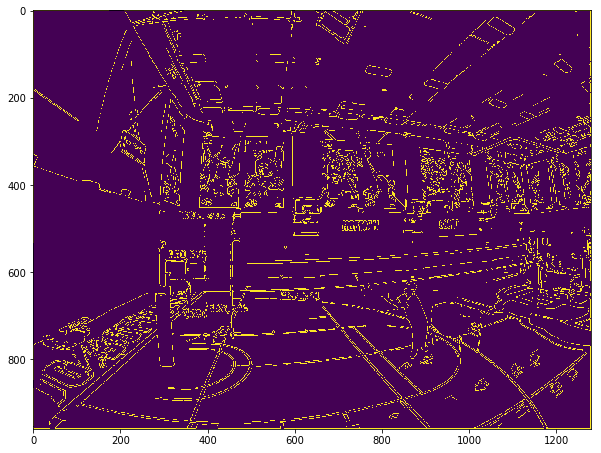

In [9]:
# image = cv2.imread('/Users/scoot/Documents/GitHub/VB-Research/Scott-Notes/Sample5-1_Moment.jpg',1)
image = cv2.imread('/home/scott/VB-Research/Scott-Notes/Sample5-1_Moment.jpg',0)

# gray = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(image,100,200)
fig = plt.figure(figsize=(10,10))
plt.imshow(edges)
lines = cv2.HoughLines(edges,1,np.pi/180,200)
# print(lines[0])
equations = []
for i in range(len(lines)):
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        x = [x1,x2]
        y = [y1,y2]
#         print("x:", x)
#         print("y:", y)
        temp = x2-x1
        if (temp) == 0:
            temp = 0.0001
        slope = float((y2-y1))/float((temp))
#         print("slope: ", slope)
        intercept = y1 - (slope*x1)
#         print("intercept:", intercept)
        equations.append((slope,intercept))
#         coeff = np.polyfit(x,y,1)
#         poly = np.poly1d(coeff)
        cv2.line(image,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('detectedLines.jpg',image)
print("num of lines:", len(equations))

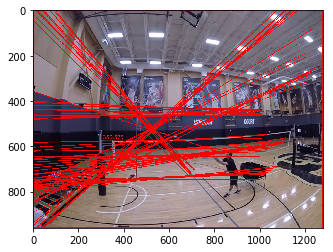

In [81]:
im2 = cv2.imread('detectedLines.jpg',1)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(im2)

before: 61
after: 46
144.00004174674837 235.64460134506226 172.99999913201333 105.12864005789186


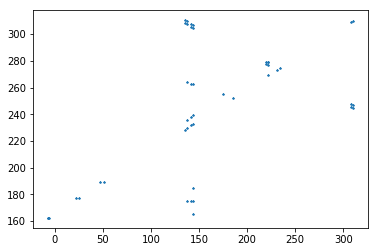

In [78]:
intersectionPoints = []
for i in range(len(equations)):
    for j in range(i+1,len(equations)):
        e1slope = equations[i][0]
        e1inter = equations[i][1]
        e2slope = equations[j][0]
        e2inter = equations[j][1]
        if((e2slope - e1slope) == 0):
            break
        xint = (e1inter - e2inter) / (e2slope - e1slope)
        yint = (e1slope * xint) + e1inter
#         print("x:",xint)
#         print("y:",yint)
        intersectionPoints.append([xint,yint])
#     here is stuff that we need to mess with 
dfIP = pd.DataFrame(intersectionPoints,columns=['x','y'])
meanx = dfIP['x'].median()
sdx = dfIP['x'].quantile(0.75) - dfIP['x'].quantile(0.25) 
meany = dfIP['y'].median()
sdy = dfIP['y'].quantile(0.75) - dfIP['y'].quantile(0.25)

print("before:",len(dfIP))
dfIP = dfIP[dfIP.x <= (meanx + 1.5*sdx)]
dfIP = dfIP[dfIP.x >= (meanx - 1.5*sdx)]

dfIP = dfIP[dfIP.y <= (meany + 1.5*sdy)]
dfIP = dfIP[dfIP.y >= (meany - 1.5*sdy)]
print("after:",len(dfIP))

print(meanx,meany,sdx,sdy)
# print(dfIP)
plt.scatter(dfIP.x,dfIP.y,marker='*',s=3)
plt.show()

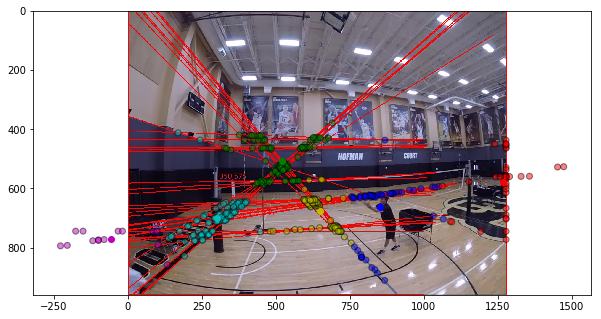

In [63]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(dfIP)
labels = kmeans.predict(dfIP)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(10, 10))
colmap = {1: 'r', 2: 'g', 3: 'b', 4:'c', 5: 'm', 6: 'y', 7: 'k', 8: 'w'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.imshow(im2)
plt.scatter(dfIP['x'], dfIP['y'], color=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])
# plt.xlim(0, 80)
# plt.ylim(0, 80)
plt.show()

In [64]:
print(centroids)
dfIP['label'] = 0
# print(dfIP)
for i in range(len(labels)):
    dfIP.iloc[i,dfIP.columns.get_loc('label')] = labels[i]
#     print(labels[i])
print(dfIP.label.unique())
print(dfIP.head(20))
dfIP.groupby('label').nunique()

[[ 1268.15034875   579.14280473]
 [  520.9984298    507.67736282]
 [  853.69050562   662.91156496]
 [  299.89549133   701.08218548]
 [  -56.34949643   771.54270509]
 [  648.06977269   675.58142484]]
[0 1 3 4 2 5]
              x           y  label
4   1278.000027  462.139572      0
5   1278.000022  559.790905      0
6   1278.000027  464.139572      0
7   1278.000016  689.176029      0
8   1278.000022  555.410328      0
9   1278.000022  557.582779      0
10  1278.000024  529.289871      0
13  1278.000020  591.570713      0
14  1278.000015  701.374748      0
15  1278.000022  565.661461      0
16  1278.000019  614.031025      0
17  1278.000022  561.777664      0
19  1278.000011  772.764862      0
20  1278.000028  437.139572      0
21  1278.000027  454.272636      0
22  1278.000022  560.307655      0
23  1278.000022  568.649197      0
24  1278.000027  451.265266      0
30  1278.000017  666.868713      0
31  1278.000020  602.111721      0


,x,y,label
label,,,
0,39,39,1
1,141,141,1
2,58,58,1
3,92,92,1
4,14,14,1
5,119,119,1


number of estimated clusters : 4


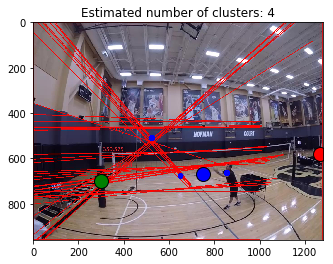

In [65]:
X, _ = make_blobs(n_samples=10000, centers=centroids, cluster_std=0.6)

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    plt.imshow(im2)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()